In [1]:
import numpy as np
from scipy import sparse
import sklearn

In [2]:
params = {}
params["lambda"] = 0.1
params["alpha"] = 0.1

params["gamma"] = 0.1*params["lambda"]


### Generating Dense Dataset

In [109]:
n = 10000;
p = 50000;
sparsity_level = 0.1;
block_size = 100


sparse_ = np.random.uniform(size=p) > sparsity_level
Beta_true = np.random.normal(size=(p))*sparse_
Beta_true = sparse.csc_matrix(Beta_true).T


X = np.random.random((n, p))
p_real = sum(sparse_)
print("Only ", p_real, "non zeros beta")
#X_real = np.random.random((n, p_real))
#X = sparse.csc_matrix((n, p))
#j = 0
#for j_real in range(p_real):
#    print(j_real)
#    while not sparse_[j]:
#    j+=1
#    X[:, j] = X_real[:, j_real:j_real+1]
#
print("X computed", X.shape, Beta_true.shape)


y = np.random.normal((X @ Beta_true), 0.01)
print("y computed")
A = 1/np.sqrt(n)*X
c = -1/n*X.T @ y

Only  44975 non zeros beta
X computed (10000, 50000) (50000, 1)
y computed


In [110]:
import matplotlib.pyplot as plt

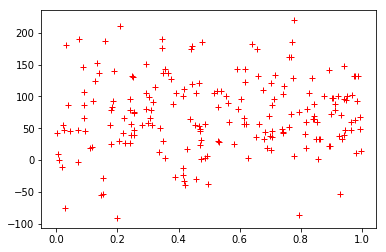

In [112]:
plt.plot(X[:200, 0], y[:200], "r+");


## Optimization

In [113]:
def penalty(z):
    return params["lambda"]*((1-params["alpha"])/2*np.linalg.norm(z, 1) + params["alpha"]*np.linalg.norm(z, 2))

In [114]:
#print(c.shape)
def lagrangian(beta, xi, z, gamma=params["gamma"]):
    #print(beta.sign, beta.curvature)
    
    first = 1/2*np.linalg.norm(A @ beta, 2) 
    third = 1/2*gamma*np.linalg.norm(beta - z, 2) ## diminue si beta = z
    second = (c - xi).T @ beta ## diminue si beta augmente
    #print(first, second, third, fourth)
    #return first.squeeze() + second.squeeze() + third.squeeze() + fourth.squeeze() + penalty(z).squeeze()
    return first + second + third + penalty(z)


In [115]:
def soft_thres(a, b):
    return -((np.abs(b) < a)*((a>0)*(a-b)+(a<=0)*(a+b)))

In [116]:
def optimal_z(beta, xi, 
              alpha=params["alpha"], 
              lambd=params["lambda"], 
              gamma=params["gamma"]):
    return soft_thres(xi-gamma*beta, lambd*alpha)/((1-alpha)*lambd+gamma)

In [ ]:
B = A.T @ A + params["gamma"]*np.eye(p)

In [ ]:
## Algo



def one_cycle_racmbadmm(p, beta, xi, z):
    num_blocks = p // block_size
    # Split in blocks
    permutation = list(range(p))
    np.random.shuffle(permutation)
    
    # Optimize beta
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        remaining_indexes = [i for i in range(p) if i not in indexes]
        #print("indexes", indexes)
        B1 = B[np.ix_(indexes, indexes)]
        B2 = B[np.ix_(indexes, remaining_indexes)]
        
        #print(block_size, B1.shape, B2.shape, beta[remaining_indexes].shape)
        #import pdb; pdb.set_trace()
        betasub_opt = - np.linalg.inv(B1)@(B2 @ beta[remaining_indexes] + (c-xi-params["gamma"]*z)[indexes])
        #model buildup
        #beta_sub = beta[indexes]
        #A_sub = A[:,indexes];
        #H_current = (A_sub).T @ A_sub;
        #c_current_sub = A_sub.T @ A @ beta - H_current @ beta_sub; # should be B_2 beta'
        #H_current = H_current + params["gamma"]*np.eye(block_size);
        
        #assert(B1 == H_current)
        #assert(c_current_sub == )
        ##print(c_current_sub.shape,  c_res[x_update_index].shape)
        #c_current = c_current_sub + (c - xi - params["gamma"]*z)[indexes]; 


        #model solver LDL factorization
        # min x^TQx+c^Tx
        # FOC (2Q+beta_kA^TA)x=-c
        
        #betasub_opt = - np.linalg.inv(H_current)@(c_current)
        beta[indexes] = betasub_opt
        #print(betasub_opt)
        #print(lagrangian(beta, xi0, z0))
        # Optimal 
        z[indexes] = optimal_z(beta[indexes], xi[indexes])
        #print(z)
    #z = optimal_z(beta, xi0)
    #print(lagrangian(beta, xi0, z))
    # Optimize xi
    xi = xi - params["gamma"]*(beta - z)
    #print(xi, params["gamma"], (beta - z))
    #print()
    #print(lagrangian(beta, xi, z))
    
    return beta, xi, z

In [ ]:
#lagrangian(Beta_true, 0, Beta_true)

In [81]:
beta0 = np.zeros((p, 1))
z0 = np.zeros((p, 1))
xi0 = np.zeros((p, 1))

In [82]:
lag = []
beta_error = []
for k in range(10): #tqdm.tqdm(range(1)):
    beta0, xi0, z0 = one_cycle_racmbadmm(p, beta0, xi0, z0)
    beta_error.append(np.linalg.norm(Beta_true - beta0, 2))
    lag.append(lagrangian(beta0, xi0, z0))
    #print()

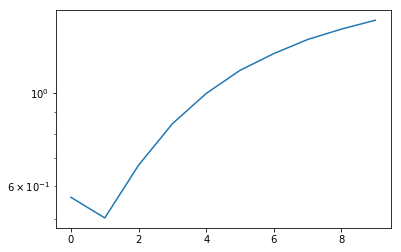

In [83]:
plt.plot(beta_error)
plt.yscale("log")
#plt.xscale("log")

## Scikit learn



In [86]:
from sklearn.linear_model import ElasticNet
sklearn_model = ElasticNet(alpha=params["lambda"], l1_ratio=params["alpha"])

In [88]:
reg_ = sklearn_model.fit(X, y)

In [92]:
reg_.coef_.shape
Beta_true[:, 0]

<1000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [93]:
np.linalg.norm(reg_.coef_ -Beta_true.todense()[:, 0])

71.78504133870189

In [ ]:
reg_.coef_;

In [ ]:
if p == 1:
    plt.plot(X[:, 0], X[:, 0:1]*Beta_true, label="True data")
    plt.plot(X[:, 0], X[:, 0] * reg_.coef_, label="Regression")
    plt.legend()

# SVM

In [94]:
## Load datasets

In [ ]:
B = A.T @ A + params["gamma"]*np.eye(p)
def one_cycle_rac_mbadmm_svm(X, y, Q):
    
    
    